In [38]:
import os
from fastai.vision.all import *
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [2]:
!git clone https://github.com/KevivJaknap/BreastCancerPrediction.git

Cloning into 'BreastCancerPrediction'...
remote: Enumerating objects: 1589, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 1589 (delta 1), reused 2 (delta 0), pack-reused 1583
Receiving objects: 100% (1589/1589), 44.20 MiB | 27.02 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [3]:
def get_labels(file_path):
    if file_path[0] == 'N':
        return 'healthy'
    else:
        return 'unhealthy'

In [4]:
def split_files(beta, base_path='/content/BreastCancerPrediction/dataset_train/'):
    healthy_files = []
    unhealthy_files = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.startswith('N'):
                healthy_files.append((base_path+file, 'healthy'))
            else:
                unhealthy_files.append((base_path+file, 'unhealthy'))
    len_healthy = len(healthy_files)
    len_unhealthy = len(unhealthy_files)


    #split into two sets
    first = healthy_files[:] + random.sample(unhealthy_files, int(len_unhealthy*beta))
    second = random.sample(healthy_files, int(len_healthy*beta)) + unhealthy_files[:]
    random.shuffle(first)
    random.shuffle(second)

    print(f"First contains {len_healthy} healthy and {len(first) - len_healthy} unhealthy")
    print(f"Second contains {len(second)-len_unhealthy} healthy and {len_unhealthy} unhealthy")
    return first, second

In [5]:
base_path = '/content/BreastCancerPrediction/dataset_train/'
class CNN:
    def __init__(self, id, files):
        self.id = id
        self.files = files
        self.dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=ColReader(0),
                   get_y=ColReader(1),
                   splitter=RandomSplitter(),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75))
        self.dls = self.dblock.dataloaders(self.files, bs=64)
        self.learn = vision_learner(self.dls, resnet34, metrics=accuracy)

    def train(self, epochs):
        self.learn.fine_tune(epochs)

    def show_batch(self):
        self.dls.show_batch()

    def save(self):
        self.learn.export(f'./models/model_{self.id}.pkl')

    def load(self):
        self.learn = load_learner(f'./models/model_{self.id}.pkl')

    def predict(self, file_path):
        img = Image.open(file_path)
        return self.learn.predict(img)

    def plot(self):
        self.learn.recorder.plot_loss()

    def show_results(self):
        self.learn.show_results()

In [7]:
files1, files2 = split_files(0.75)
files0 = split_files(1)[0]
model0 = CNN(id = 0, files = files0)
model1 = CNN(id = 1, files = files1)
model2 = CNN(id = 2, files = files2)
model0.train(4)
model1.train(4)
model2.train(4)

First contains 642 healthy and 480 unhealthy
Second contains 481 healthy and 640 unhealthy
First contains 642 healthy and 640 unhealthy
Second contains 642 healthy and 640 unhealthy


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 93.2MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.845481,0.318901,0.878906,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.370246,0.228788,0.902344,00:12
1,0.300383,0.159483,0.968750,00:13
2,0.235977,0.147221,0.976562,00:16
3,0.189589,0.143518,0.972656,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.839992,0.811414,0.758929,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.352411,0.588690,0.763393,00:10
1,0.274676,0.124703,0.937500,00:10
2,0.230346,0.089511,0.950893,00:10
3,0.199928,0.067790,0.964286,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.883705,0.323405,0.861607,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.430045,0.201927,0.915179,00:13
1,0.346144,0.999939,0.776786,00:10
2,0.263755,0.114556,0.959821,00:11
3,0.208128,0.178834,0.946429,00:11


In [29]:
def accuracy(iter1, iter2):
  if len(iter1) != len(iter2):
    return None
  count = 0
  for i in range(len(iter1)):
    if iter1[i] == iter2[i]:
      count += 1

  return count*100/len(iter1)
def get_test_accuracy(model):
  test_path = '/content/BreastCancerPrediction/dataset_test/'
  test_xy = split_files(1, base_path=test_path)[0]
  x, y = [], []
  for a, b in test_xy:
    x.append(a)
    y.append(b)
  test_dl = model.dls.test_dl(x)
  preds = model.learn.get_preds(dl=test_dl)
  preds = preds[0].argmax(dim=1)
  preds = [model.dls.vocab[i] for i in preds]
  return accuracy(preds, y), len(preds)

def get_test_values(model):
  test_path = '/content/BreastCancerPrediction/dataset_test/'
  test_xy = split_files(1, base_path=test_path)[0]
  x, y = [], []
  for a, b in test_xy:
    x.append(a)
    y.append(b)
  test_dl = model.dls.test_dl(x)
  preds = model.learn.get_preds(dl=test_dl)
  preds = preds[0].argmax(dim=1)
  preds = [model.dls.vocab[i] for i in preds]
  return y, preds


In [36]:
def plot(y_actual, y_preds):
  # Compute the confusion matrix
  cm = confusion_matrix(y_actual, y_preds)

  # Plot the confusion matrix
  plt.figure(figsize=(10,10))
  sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues', xticklabels=['healthy', 'unhealthy'], yticklabels=['healthy', 'unhealthy']);
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  plt.title('Confusion Matrix', size = 15);
  plt.show()

In [39]:
def get_metrics(y_actual, y_preds):
# Compute the metrics
  accuracy = accuracy_score(y_actual, y_preds)
  f1 = f1_score(y_actual, y_preds, average='weighted')
  precision = precision_score(y_actual, y_preds, average='weighted')
  recall = recall_score(y_actual, y_preds, average='weighted')

  return {'accuracy': accuracy, 'f1': f1, 'precision': precision, 'recall': recall}

First contains 120 healthy and 120 unhealthy
Second contains 120 healthy and 120 unhealthy


{'accuracy': 0.9375, 'f1': 0.9372549019607843, 'precision': 0.9444444444444444, 'recall': 0.9375}


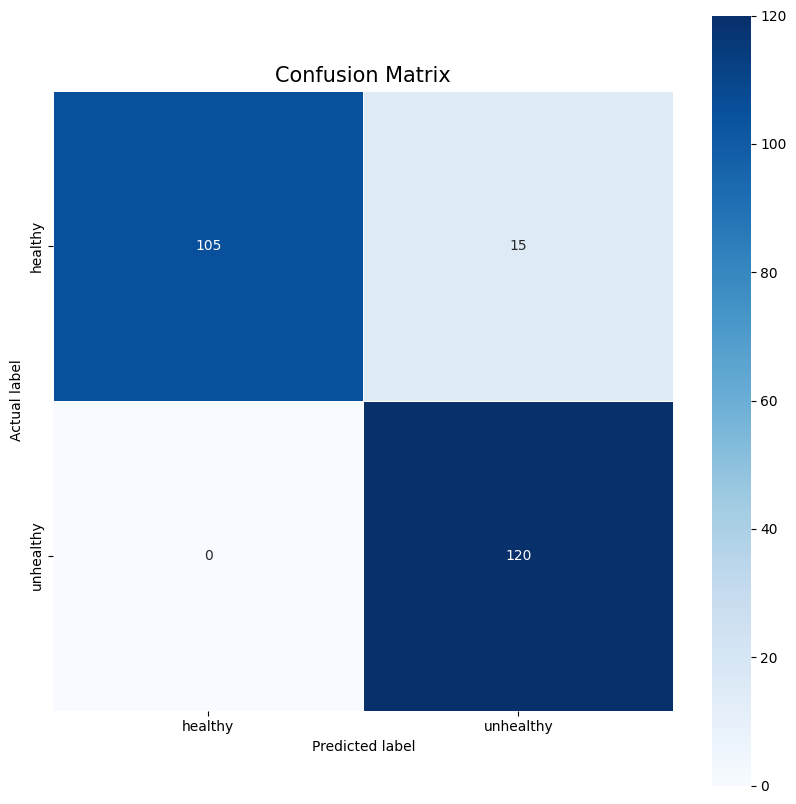

In [40]:
y_actual, y_preds = get_test_values(model0)
print(get_metrics(y_actual, y_preds))
plot(y_actual, y_preds)

In [ ]:
from fastai.callback.hook import *

# Define a hook function
def hook_fn(m, i, o): return o.detach().clone()

# Register the hook on the last layer
hook_output = Hook(learn.model[-1], hook_fn, is_forward=True)

# Get some input data
x, = first(dls.valid)

# Get the outputs of the last layer (logits)
with torch.no_grad():
    outputs = learn.model.eval()(x)

# Get the logits from the hooked layer
logits = hook_output.stored

In [44]:
from fastai.callback.hook import *

def hook_fn(m, i, o): return o.detach().clone()

hook_output = Hook(model0.learn.model[-1], hook_fn, is_forward=True)

img = PILImage.create(files0[0][0])

# Predict
pred,pred_idx,probs = model0.learn.predict(img)

# Print the prediction
print(f'Prediction: {pred}')
print(f'Probability: {probs[pred_idx]}')
logits = hook_output.stored

Prediction: unhealthy
Probability: 0.9960760474205017


In [45]:
print(logits)

tensor([[-1.5413,  3.9954]], device='cuda:0')
